In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage import exposure
import cv2
from joblib import Parallel, delayed
!pip install pydicom
import pydicom
from pydicom import dcmread
from sklearn.utils import resample # Handle Imbalance
import pathlib
import PIL

In [3]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 8.8MB/s eta 0:00:01
     |████████████████████████████████| 51kB 5.8MB/s  eta 0:00:01
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
#!pip install keras_unet

In [ ]:
#!pip install -U segmentation-models==0.2.1

In [4]:
!pip install tensorflow_io

     |████████████████████████████████| 25.3MB 1.4MB/s 


In [ ]:
!pip list

In [3]:
import tensorflow as tf
import keras
import os
import imgaug.augmenters as iaa
from PIL import Image
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape,Flatten,MaxPooling2D,concatenate,UpSampling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard,CSVLogger
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import random as rn
import tensorflow_io as tfio

# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
#import segmentation_models as sm
#from segmentation_models import Unet
# sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')
#from segmentation_models.metrics import iou_score

Using TensorFlow backend.


In [4]:
from glob import glob
import pathlib
import pydicom as dicom


In [5]:
os.chdir('/gdrive/MyDrive/Image_Segementation_CS2/')

In [6]:
dataset = pd.read_csv('siim/train-rle.csv')
dataset.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [ ]:
data_dir = pathlib.Path("siim")
train_read = sorted(data_dir.glob('dicom-images-train/**/*.dcm'))
test_read  = sorted(data_dir.glob('dicom-images-test/**/*.dcm'))

In [ ]:
missing_images = 0
train_df =[]
remove =[]

for j,i in enumerate(tqdm(train_read)):


  sample = dicom.dcmread(i) # reading each input
  train ={}
  train['UID'] = sample.SOPInstanceUID

  try: # try and except , to avoid throwing and error in case of missing files
    
    encoded_pixel = dataset[dataset['ImageId'] == train['UID']].values [0][1] # Checking each input is present in csv or not
    train['Encoded_pixel'] = encoded_pixel
  except:
    missing_images+=1
    remove.append('siim/dicom-images-train/'+sample.StudyInstanceUID+'/'+sample.SeriesInstanceUID+'/'+sample.SOPInstanceUID+'.dcm')
    # if the image details are not ppresent in CSV means, file is missing
  
  train['Path'] = 'siim/dicom-images-train/'+sample.StudyInstanceUID+'/'+sample.SeriesInstanceUID+'/'+sample.SOPInstanceUID+'.dcm' # saving for fucture references 
  
  train_df.append(train)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
df_main = pd.DataFrame(train_df,columns=['UID','Encoded_pixel','Path'])
df_main.head()

,UID,Encoded_pixel,Path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....


In [ ]:
df_main = df_main.loc[~df_main['Path'].isin(remove)] #remove the row which dont have image.
df_main.head()

,UID,Encoded_pixel,Path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....


In [ ]:
df_downsampled = df_main[df_main['Encoded_pixel']!= '-1']
df_downsampled.drop('UID',axis=1,inplace=True)
df_downsampled.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Encoded_pixel,Path
6,209126 1 1019 6 1015 10 1012 13 1010 14 1008 1...,siim/dicom-images-train/1.2.276.0.7230010.3.1....
13,49820 3 1017 11 1012 13 1009 16 1007 18 1006 1...,siim/dicom-images-train/1.2.276.0.7230010.3.1....
14,261328 6 1015 11 1011 15 1007 18 1004 21 1002 ...,siim/dicom-images-train/1.2.276.0.7230010.3.1....
18,592184 33 976 58 956 73 941 88 926 102 917 109...,siim/dicom-images-train/1.2.276.0.7230010.3.1....
28,530522 1 1022 3 1019 6 1017 7 1016 9 1014 10 1...,siim/dicom-images-train/1.2.276.0.7230010.3.1....


In [ ]:
df_main.to_csv('Main_CS2_SIIM_All.csv',index=False)

In [ ]:
df_downsampled.to_csv('Main_CS2_SIIM.csv',index=False)

In [6]:
# Read a saved files
df_main = pd.read_csv('Main_CS2_SIIM_All.csv')
df_downsampled = pd.read_csv('Main_CS2_SIIM.csv') # Only negative sampled.

In [7]:
df_main.head(3)

,UID,Encoded_pixel,Path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....


In [12]:
df_downsampled.head(3)

,Encoded_pixel,Path
0,209126 1 1019 6 1015 10 1012 13 1010 14 1008 1...,siim/dicom-images-train/1.2.276.0.7230010.3.1....
1,49820 3 1017 11 1012 13 1009 16 1007 18 1006 1...,siim/dicom-images-train/1.2.276.0.7230010.3.1....
2,261328 6 1015 11 1011 15 1007 18 1004 21 1002 ...,siim/dicom-images-train/1.2.276.0.7230010.3.1....


In [8]:
# create classfication problem
label =[]
for i in tqdm(df_main['Encoded_pixel']):
  if i =='-1':
    label.append(0)
  else:
    label.append(1)  

df_main['Label'] = label
df_main.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,UID,Encoded_pixel,Path,Label
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....,0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....,0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....,0


In [9]:
df_downsampled = df_main[['Path','Label']]
df_downsampled.head(3)

,Path,Label
0,siim/dicom-images-train/1.2.276.0.7230010.3.1....,0
1,siim/dicom-images-train/1.2.276.0.7230010.3.1....,0
2,siim/dicom-images-train/1.2.276.0.7230010.3.1....,0


# **MODEL**


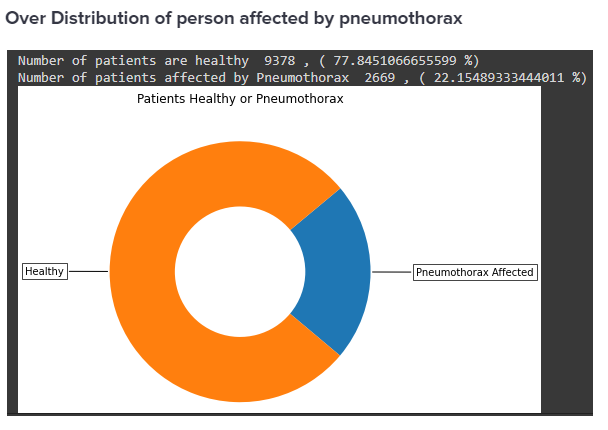

In [29]:
file_path  = df_downsampled['Path'].values
labels     = df_downsampled['Label'].values


## Why use Tf.Dataset pipeline?

<pre>

<font color ='blue'>
The tf. data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training.
The Dataset API allows you to build an asynchronous, highly optimized data pipeline to prevent your GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches, and sends it to the GPU. Former data pipelines made the GPU wait for the CPU to load the data, leading to performance issues.

</font>
</pre>

In [31]:
train_ds = tf.data.Dataset.from_tensor_slices((file_path,label))
train_ds = train_ds.shuffle(len(df_downsampled),seed=42)
train_ds
#test_ds = tf.data.Dataset.from_tensor_slices((test_path,test_mask))


<ShuffleDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [33]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  #image_bytes = tf.io.read_file(img)
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')

  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape (1,1024,1024,1) and we want (1024,1024,3) 
  b = tf.constant([1,1,3], tf.int32) 
  image=tf.tile(image,b)
  image=tf.image.resize(image,size=[256,256]) #the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  # resize the image to the desired size
  return image
  
def process_path(file_path,label):
  img = tf.io.read_file(file_path) #reading the image from the file path
  img = decode_img(img) #passing the image to the function
  return img,label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
train_ds

<ParallelMapDataset shapes: ((256, 256, None), ()), types: (tf.float32, tf.int32)>

In [34]:
val_size = int(len(df_downsampled)*0.2) #splitting to 80-20 data
train_ds = train_ds.skip(val_size)
test_ds = train_ds.take(val_size)

In [49]:
train_dataset_new  = train_ds.batch(64)
test_dataset_new  =  test_ds.batch(64,drop_remainder=True)

In [50]:
train_dataset_new

<BatchDataset shapes: ((None, 256, 256, None), (None,)), types: (tf.float32, tf.int32)>

In [51]:
test_dataset_new

<BatchDataset shapes: ((64, 256, 256, None), (64,)), types: (tf.float32, tf.int32)>

In [52]:
train_ds

<SkipDataset shapes: ((256, 256, None), ()), types: (tf.float32, tf.int32)>

In [53]:
test_ds

<TakeDataset shapes: ((256, 256, None), ()), types: (tf.float32, tf.int32)>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


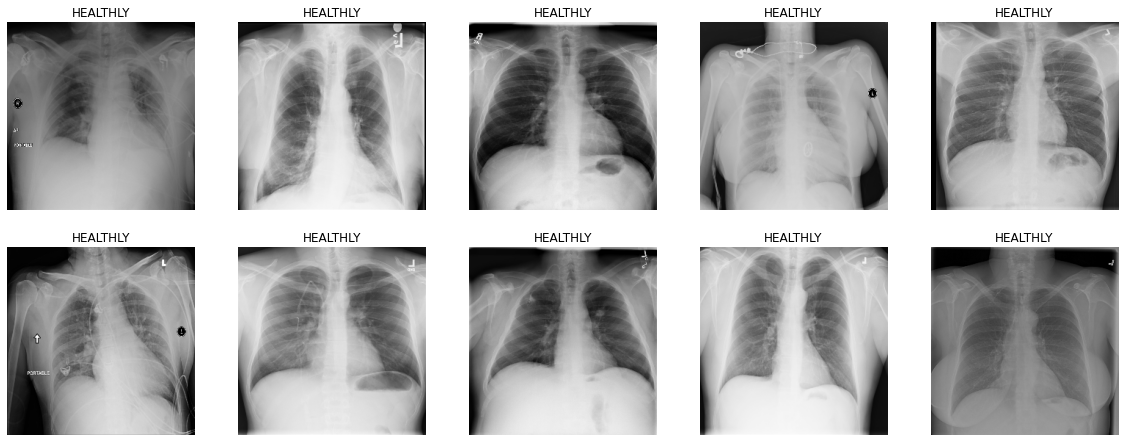

In [41]:
plt.figure(figsize=(20,20)) #plotting images from the train as a sanity check of whether the data has been properly converted or not
count=0
for i,j in tqdm(train_ds.take(10)):
  ax = plt.subplot(5,5,count+1)
  count=count+1
  if j==0:
    plt.title("HEALTHLY")
  else:
    plt.title("PNEUMOTHORAX")
  plt.imshow(i)
  plt.axis("off")

In [42]:
from tensorflow.keras import applications

In [43]:
# VGG16 as Backbone
model_1 =tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (256,256,3))
for i in model_1.layers:
  i.trainable=False
model=model_1.output
model=Conv2D(32, (3, 3))(model)
model=(Activation('relu'))(model)
model=(MaxPool2D(pool_size=(2, 2)))(model)
model=Flatten()(model)
model = Dense(256, activation="relu")(model)
model = Dense(128, activation="relu")(model)
output_layer = Dense(1, activation="sigmoid")(model)
model1 = Model(model_1.input,output_layer)


In [44]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [45]:
%load_ext tensorboard
import datetime
folder_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create log folder - TensorBoard
log_dir="/gdrive/My Drive/Image_segmentation/segmentation/logs/fit/" + folder_name
tensorboard_callback =TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

print('Folder_name', folder_name)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_recall', min_delta=0, patience=30, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#Saving the best model
filepath="new_model_save_test/best_models_classification.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                  monitor='val_recall',
                                  mode='max',
                                  verbose=1,
                                  save_best_only=True)



Folder_name 20210412-055354


In [57]:
opti = tf.keras.optimizers.Adam(lr=0.0001)
model1.compile(loss = "binary_crossentropy", optimizer =opti, metrics=["accuracy", tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])
model1.fit(train_dataset_new,epochs=50,verbose=1,validation_data=test_dataset_new,batch_size=64,callbacks=[checkpoint,tensorboard_callback,early_stop])

Epoch 1/50
151/151 [==============================] - 2417s 13s/step - loss: 0.5079 - accuracy: 0.7808 - precision: 0.3866 - recall: 0.0101 - val_loss: 0.4362 - val_accuracy: 0.7927 - val_precision: 0.6434 - val_recall: 0.1572

Epoch 00001: val_recall improved from -inf to 0.15720, saving model to new_model_save_test/best_models_classification.h5
Epoch 2/50
151/151 [==============================] - 348s 2s/step - loss: 0.4380 - accuracy: 0.7932 - precision: 0.6048 - recall: 0.2093 - val_loss: 0.3994 - val_accuracy: 0.8150 - val_precision: 0.6502 - val_recall: 0.3724

Epoch 00002: val_recall improved from 0.15720 to 0.37240, saving model to new_model_save_test/best_models_classification.h5
Epoch 3/50
151/151 [==============================] - 347s 2s/step - loss: 0.3955 - accuracy: 0.8127 - precision: 0.6687 - recall: 0.3319 - val_loss: 0.3600 - val_accuracy: 0.8345 - val_precision: 0.6918 - val_recall: 0.4008

Epoch 00003: val_recall improved from 0.37240 to 0.40079, saving model to n

In [62]:
model1.evaluate(test_dataset_new)

37/37 [==============================] - 92s 1s/step - loss: 0.0134 - accuracy: 0.9992 - precision: 0.9962 - recall: 1.0000


[0.013419254682958126, 0.9991554021835327, 0.9962049126625061, 1.0]

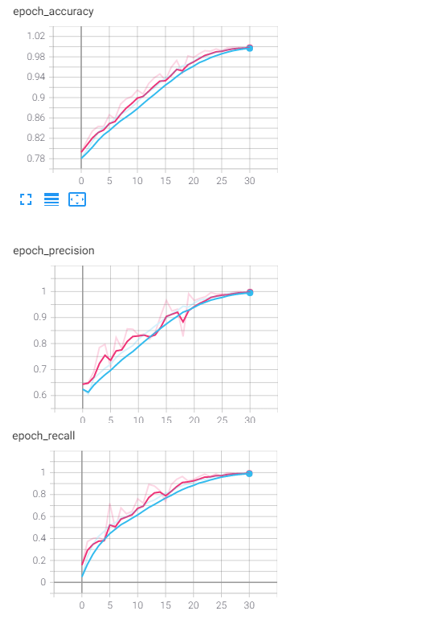

# Confusion Matrix on Train Data with different threshold

In [80]:
os.chdir('/gdrive/MyDrive/Image_Segementation_CS2/')
import seaborn as sns
from sklearn.metrics import confusion_matrix
def confusion_mat(test_y,predict_y):
  ''' Function to Visualize the Confusion Matrix'''
  labels = [0,1]
  plt.figure(figsize=(6,6))
  cmap=sns.light_palette("blue")
  C = confusion_matrix(test_y, predict_y)
  print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
  sns.heatmap(C, cmap="Blues",annot=True,annot_kws={"size": 16},fmt='g')
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title('Confusion matrix')
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



Percentage of misclassified points  0.13488275575845612


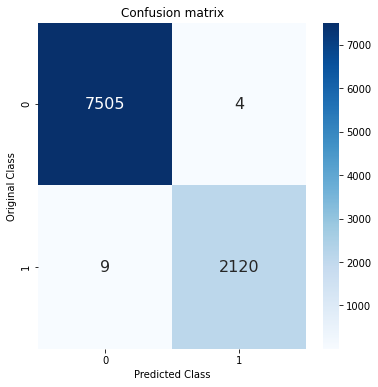

In [83]:
y_pred_1=[] #array to store predicted label
y_true=[] #array to store the ground truth
for i,j in tqdm(train_dataset_new.take(9638)):
  
  y_pred_1.extend(model1.predict(i)) #predicting each batch
  y_true.extend(j)
  y_pred=[]
for i in y_pred_1: #the values are in probabilities and hence we are going to classify based on acustom threshold (0.5 is the default threshold)
  if i[0]>=0.5: #setting threshold
    y_pred.append(1)
  else:
    y_pred.append(0)
y_true=np.array(y_true) #converting the array for into numpy
y_pred=np.array(y_pred).reshape(1,-1)
y_pred=y_pred[0]
confusion_mat(y_true,y_pred)

Percentage of misclassified points  0.11413156256484748


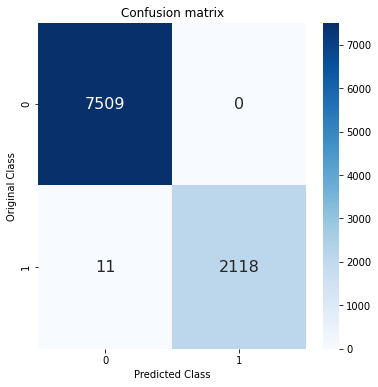

In [87]:
y_pred =[]
for i in y_pred_1: #the values are in probabilities and hence we are going to classify based on acustom threshold (0.5 is the default threshold)
  if i[0]>=0.6: #setting threshold
    y_pred.append(1)
  else:
    y_pred.append(0)
y_true=np.array(y_true) #converting the array for into numpy
y_pred=np.array(y_pred).reshape(1,-1)
y_pred=y_pred[0]
confusion_mat(y_true,y_pred)

Percentage of misclassified points  0.13488275575845612


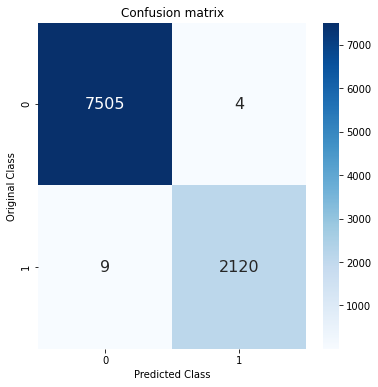

In [104]:
y_pred =[]
for i in y_pred_1: #the values are in probabilities and hence we are going to classify based on acustom threshold (0.5 is the default threshold)
  if i[0]>=0.5: #setting threshold
    y_pred.append(1)
  else:
    y_pred.append(0)
y_true=np.array(y_true) #converting the array for into numpy
y_pred=np.array(y_pred).reshape(1,-1)
y_pred=y_pred[0]
confusion_mat(y_true,y_pred)

Percentage of misclassified points  0.1452583523552604


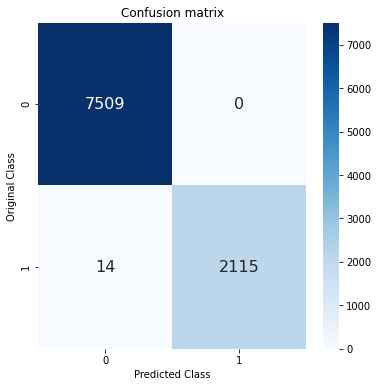

In [93]:
y_pred =[]
for i in y_pred_1: #the values are in probabilities and hence we are going to classify based on acustom threshold (0.5 is the default threshold)
  if i[0]>=0.6: #setting threshold
    y_pred.append(1)
  else:
    y_pred.append(0)
y_true=np.array(y_true) #converting the array for into numpy
y_pred=np.array(y_pred).reshape(1,-1)
y_pred=y_pred[0]
confusion_mat(y_true,y_pred)

## Confusion Matrix on test Data with different threshold

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



Percentage of misclassified points  0.09338036937123885


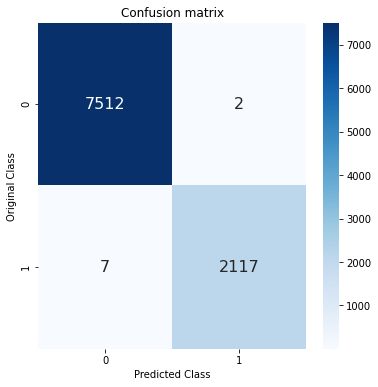

In [106]:
y_pred_1=[] #array to store predicted label
y_true=[] #array to store the ground truth
for i,j in tqdm(train_dataset_new.take(2129)):
  
  y_pred_1.extend(model1.predict(i)) #predicting each batch
  y_true.extend(j)
  y_pred=[]
for i in y_pred_1: #the values are in probabilities and hence we are going to classify based on acustom threshold (0.5 is the default threshold)
  if i[0]>=0.5: #setting threshold
    y_pred.append(1)
  else:
    y_pred.append(0)
y_true=np.array(y_true) #converting the array for into numpy
y_pred=np.array(y_pred).reshape(1,-1)
y_pred=y_pred[0]
confusion_mat(y_true,y_pred)

Percentage of misclassified points  0.08300477277443453


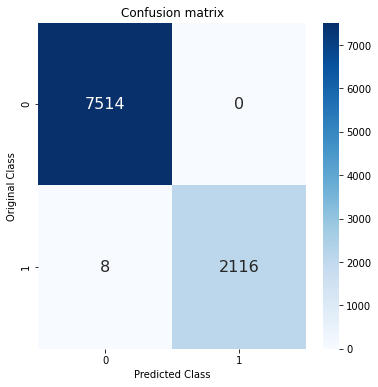

In [107]:
y_pred =[]
for i in y_pred_1: #the values are in probabilities and hence we are going to classify based on acustom threshold (0.5 is the default threshold)
  if i[0]>=0.6: #setting threshold
    y_pred.append(1)
  else:
    y_pred.append(0)
y_true=np.array(y_true) #converting the array for into numpy
y_pred=np.array(y_pred).reshape(1,-1)
y_pred=y_pred[0]
confusion_mat(y_true,y_pred)

Percentage of misclassified points  0.11413156256484748


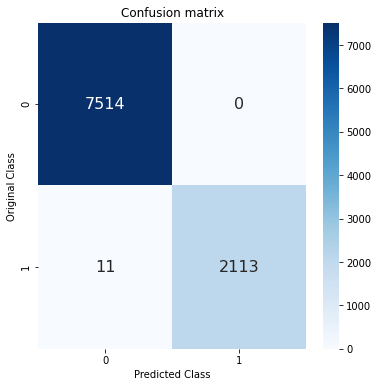

In [108]:
y_pred =[]
for i in y_pred_1: #the values are in probabilities and hence we are going to classify based on acustom threshold (0.5 is the default threshold)
  if i[0]>=0.65: #setting threshold
    y_pred.append(1)
  else:
    y_pred.append(0)
y_true=np.array(y_true) #converting the array for into numpy
y_pred=np.array(y_pred).reshape(1,-1)
y_pred=y_pred[0]
confusion_mat(y_true,y_pred)

#  Observation
1. 0.5 as the threshold is better than the other thresholds for reducing False negatives
2. As the threshold increases the number of False negatives increases